In [38]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


In [20]:
data = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df = pd.DataFrame(data)

df.head()
df.shape

(22424, 3)

# splitting the train folder into train and validation data, as we don't have any other data that can act as validation data, the test data contains only images, hence it can't be used as validation data

In [21]:
!pip install split-folders
import splitfolders

trainDirectory = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(trainDirectory, output="newDataset",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

^C
ERROR: Operation cancelled by user


In [ ]:
trainDirectory='/kaggle/working/newDataset/train'
validationDirectory='/kaggle/working/newDataset/val'
os.listdir(trainDirectory), os.listdir(validationDirectory)

In [31]:
img=trainDirectory+'/c0/img_80288.jpg'
a=imread(img)

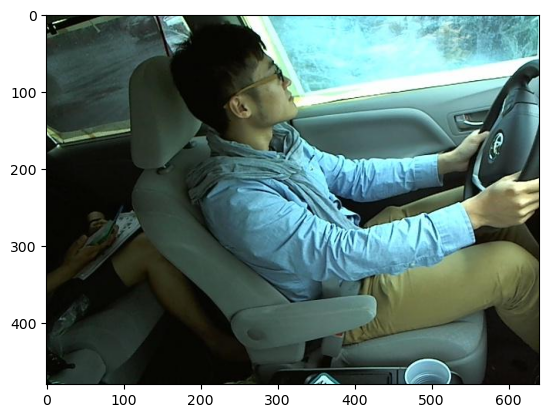

In [32]:
plt.imshow(a)

In [33]:
imageShape=(256,256,3)

In [ ]:
trainGenerator=ImageDataGenerator(
                                  rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,)
valGenerator=ImageDataGenerator(
                               )

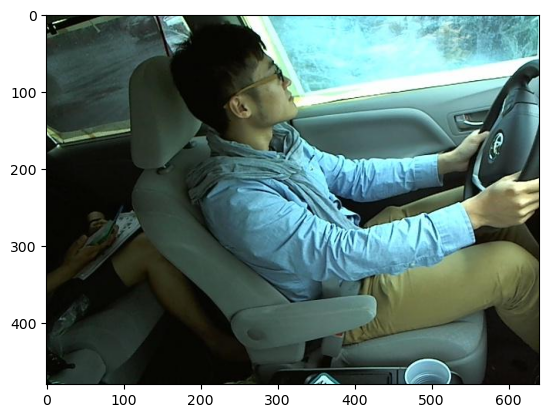

In [34]:
img=trainDirectory+'/c0/img_80288.jpg'
a=imread(img)
plt.imshow(a)

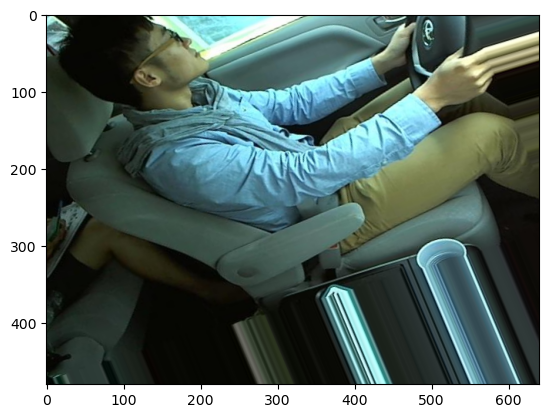

In [36]:
plt.imshow(trainGenerator.random_transform(a))

In [ ]:
augmented_train_data=trainGenerator.flow_from_directory(trainDirectory,
                                                       target_size=imageShape[:2],
                                                       batch_size=32,
                                                       class_mode='categorical'
                                                       )

In [ ]:
val_data=valGenerator.flow_from_directory(validationDirectory,
                                         target_size=imageShape[:2],
                                         batch_size=32,
                                         class_mode='categorical')

# **MODEL 1**

In [24]:
from keras import layers
from keras import models

model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Dropout(0.2))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(512, activation='relu'))
model_aug.add(layers.Dropout(0.3))
model_aug.add(layers.Dense(128, activation='relu'))
model_aug.add(layers.Dropout(0.2))
model_aug.add(layers.Dense(10, activation='softmax'))

model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_aug=model_aug.fit(
      augmented_train_data,
    batch_size=32,
      epochs=5,
      validation_data=val_data)

Epoch 1/5


2024-03-10 12:48:53.093369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


561/561 [==============================] - 297s 502ms/step - loss: 2.1154 - accuracy: 0.2259 - val_loss: 1.7046 - val_accuracy: 0.3742
Epoch 2/5
561/561 [==============================] - 265s 473ms/step - loss: 1.1796 - accuracy: 0.5748 - val_loss: 0.5133 - val_accuracy: 0.8314
Epoch 3/5
561/561 [==============================] - 263s 469ms/step - loss: 0.7339 - accuracy: 0.7464 - val_loss: 0.4234 - val_accuracy: 0.8644
Epoch 4/5
561/561 [==============================] - 264s 470ms/step - loss: 0.5377 - accuracy: 0.8197 - val_loss: 0.5556 - val_accuracy: 0.8198
Epoch 5/5
561/561 [==============================] - 263s 468ms/step - loss: 0.4543 - accuracy: 0.8501 - val_loss: 0.8248 - val_accuracy: 0.7530


**We achive an accuracy of 85%, to enhance this we will incorporate a hybrid CNN model which does feature extraction from three pretrained CNN Models followed by feature concatanation and classification layers**

# HYBRID MODEL

In [28]:
xception = tf.keras.applications.xception.Xception(
                            include_top=False, 
                             weights='imagenet',
                             input_shape=(256,256,3)
)
xception.trainable=False

eff = tf.keras.applications.EfficientNetB0(
                            include_top=False, 
                             weights='imagenet',
                             input_shape=(256,256,3)
)

eff.trainable=False

vgg=tf.keras.applications.vgg16.VGG16(include_top=False, 
                             weights='imagenet',
                             input_shape=(256,256,3))
vgg.trainable=False


input_shape = (256, 256, 3)

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = xception(inputs, training=False)
y = eff(inputs, training=False)
z = vgg(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer1")(x)
y = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer2")(y)
z = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer3")(z)

x = tf.keras.layers.Concatenate(axis=1)([x, y, z])

x = tf.keras.layers.Dense(128, activation="relu", name="hidden")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

print(model_1.summary())


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 8, 8, 2048)   20861480    ['input_layer[0][0]']            
                                                                                                  
 efficientnetb0 (Functional)    (None, 8, 8, 1280)   4049571     ['input_layer[0][0]']            
                                                                                                  
 vgg16 (Functional)          

In [29]:
history = model_1.fit(
  augmented_train_data,
  validation_data=val_data,
  callbacks=[earlyStop],
  epochs=10
)

Epoch 1/10
561/561 [==============================] - 312s 534ms/step - loss: 1.5718 - accuracy: 0.5185 - val_loss: 0.6817 - val_accuracy: 0.7842
Epoch 2/10
561/561 [==============================] - 298s 532ms/step - loss: 0.6120 - accuracy: 0.8091 - val_loss: 0.4133 - val_accuracy: 0.8693
Epoch 3/10
561/561 [==============================] - 296s 527ms/step - loss: 0.4140 - accuracy: 0.8699 - val_loss: 0.5288 - val_accuracy: 0.8354
Epoch 4/10
561/561 [==============================] - 295s 526ms/step - loss: 0.3145 - accuracy: 0.9005 - val_loss: 0.2881 - val_accuracy: 0.9122
Epoch 5/10
561/561 [==============================] - 295s 526ms/step - loss: 0.2785 - accuracy: 0.9094 - val_loss: 0.2070 - val_accuracy: 0.9323
Epoch 6/10
561/561 [==============================] - 298s 531ms/step - loss: 0.2541 - accuracy: 0.9185 - val_loss: 0.1769 - val_accuracy: 0.9410
Epoch 7/10
561/561 [==============================] - 296s 528ms/step - loss: 0.2388 - accuracy: 0.9228 - val_loss: 0.2135 -

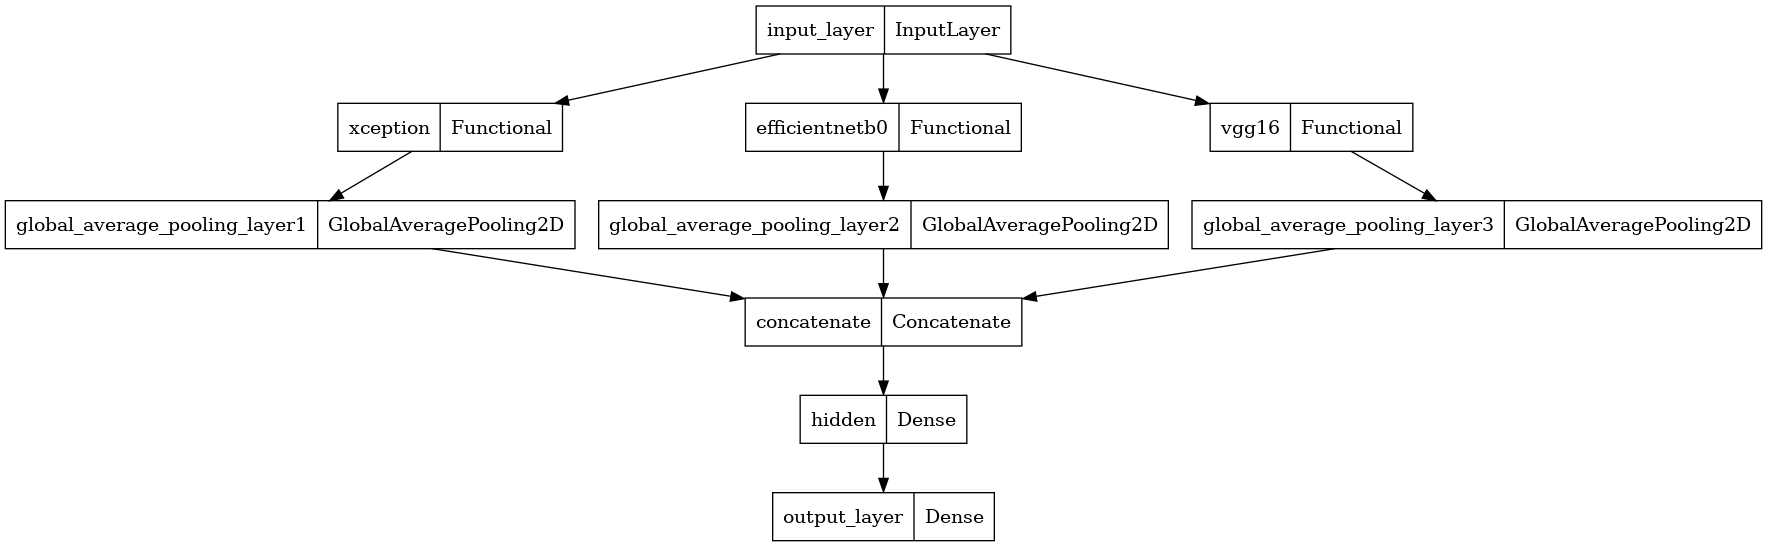

In [30]:
tf.keras.utils.plot_model(
    model_1,
    to_file="model.png",
)

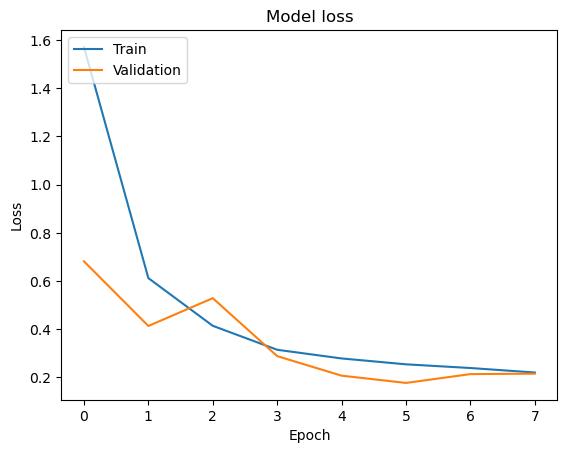

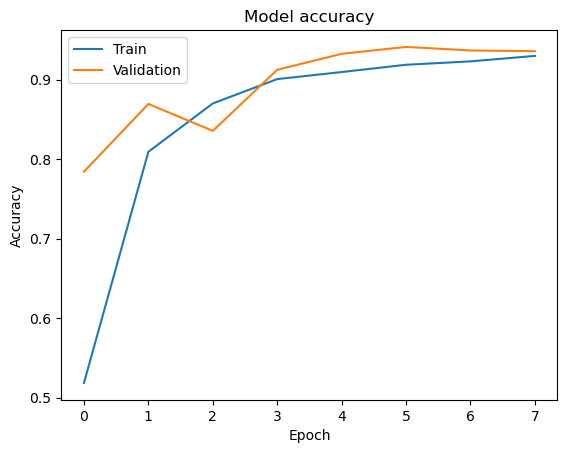

141/141 [==============================] - 31s 203ms/step


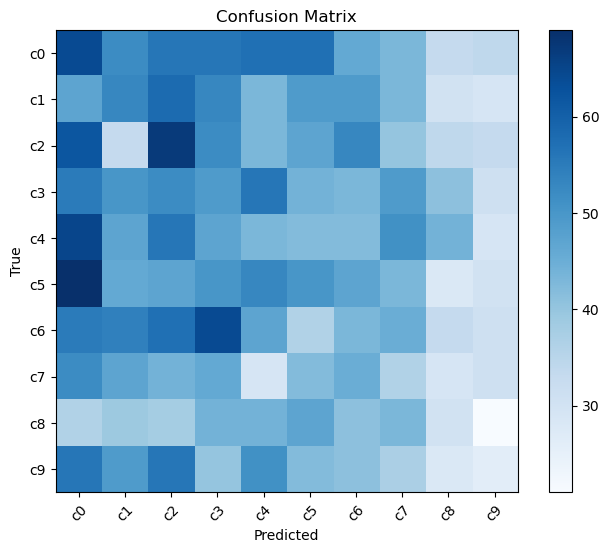

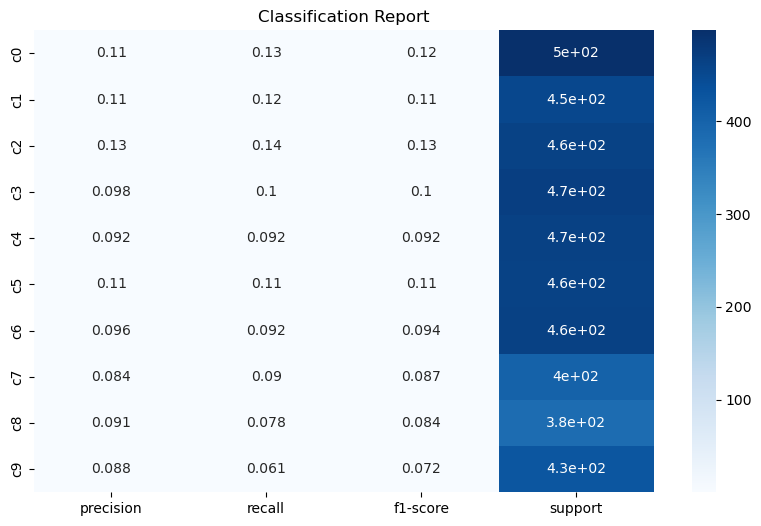

In [39]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0), annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()


plot_loss(history)
plot_accuracy(history)

val_data.reset()
y_true = val_data.classes
y_pred = model_1.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)
class_names = val_data.class_indices.keys()
plot_confusion_matrix(y_true, y_pred, class_names)
plot_classification_report(y_true, y_pred, class_names)
